# __Hands-on with TensorFlow: Part A__

Let's see how TensorFlow works and build a deep neural network model using the MNIST dataset.

## Steps to be followed:
1. Import TensorFlow
2. Load the MNIST dataset
3. Create the model
4. Get predictions from the model
5. Apply softmax activation to the predictions
6. Define the loss function
7. Compile the model
8. Train the model
9. Evaluate the model
10. Create a probability model
11. Visual prediction analysis

## Step 1: Import TensorFlow

- Import TensorFlow and check its version.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # Force CPU usage to avoid CUDA warnings

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


## Step 2: Load the MNIST dataset

- Load the MNIST dataset and normalize the input data by dividing the train and test sets by 255. The pixel values of the images are divided by 255.0 to normalize them to the range [0, 1]



The MNIST dataset is a large collection of handwritten digits commonly used for training and testing in the field of machine learning. It is one of the most well-known datasets for evaluating the performance of image processing and pattern recognition algorithms.

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

__Observation:__
- The dataset has been downloaded.

### Visualize the MNIST Dataset

Let's look at some examples from the MNIST dataset to understand what we're working with:

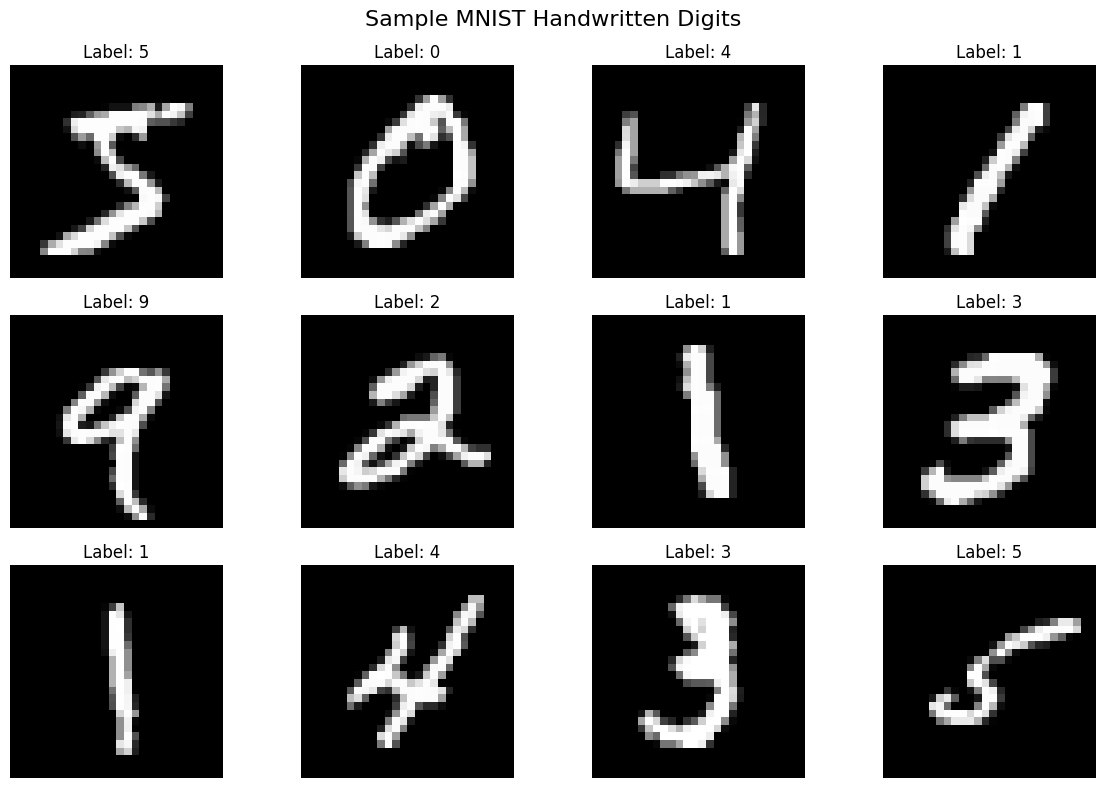

Training set: 60000 images of 28x28 pixels
Test set: 10000 images
Pixel value range: 0.0 to 1.0
Classes: [np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]


In [3]:
# Display the first 12 images from the training set
plt.figure(figsize=(12, 8))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.suptitle('Sample MNIST Handwritten Digits', fontsize=16)
plt.tight_layout()
plt.show()

# Print dataset information
print(f"Training set: {x_train.shape[0]} images of {x_train.shape[1]}x{x_train.shape[2]} pixels")
print(f"Test set: {x_test.shape[0]} images")
print(f"Pixel value range: {x_train.min():.1f} to {x_train.max():.1f}")
print(f"Classes: {sorted(set(y_train))}")

## Step 3: Create the model

- Create a Sequential model with flatten, dense, and dropout layers.

### Peeling Back the Layers

1. Input Layer
- We need one input layer to ingest the input variables
- For MNIST, each image is 28 x 28 pixels, 256 grayscale 

2. Flatten Layer
- Neural networks expect vectors as input to our next layer, the Dense layer
- The Flatten layer converts the 2D image (28 x 28) into a 1D vector of 784 values

3. Hidden Dense Layer
- A fully connected layer with 128 neurons, a common sweet spot large enough to capture patterns yet small enough to train on a laptop
- Each neuron learns from a weighted combination of the 784 inputs
- RelU introduces nonlinearity, allowing the model to learn complex patterns
- This layer acts like a feature extractor, learning abstract patterns in digits (edges, curves, strokes, etc.)

4. Dropout Layer
- Randomly set a percentage of neurons to 0 in each batch (we selected 20% for starters)
- Prevents overfitting
- Encourages the network to learn more robust features

5. Output Layer
- Outputs 10 values (called logits, raw, unnormalized scores), one for each of the 10 classes (digits, 0-9)
- No activation required in this layer because we are going to compute the cross entropy, which applies softmax
- The highest logit = the predicted digit

In [86]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

## Step 4: Get predictions from the model

- Get the predictions from the model using the train data for one column, as the optimizer is not yet applied.


In [87]:
# Display model summary
print("Model Architecture:")
model.summary()

print("\nKey Points:")
print("• Input: 28x28 pixel images (784 features after flattening)")
print("• Hidden layer: 128 neurons with ReLU activation")
print("• Dropout: 20% of neurons randomly turned off during training")
print("• Output: 10 neurons (one for each digit class 0-9)")
print(f"• Total trainable parameters: {model.count_params():,}")

Model Architecture:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_6 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)


Key Points:
• Input: 28x28 pixel images (784 features after flattening)
• Hidden layer: 128 neurons with ReLU activation
• Dropout: 20% of neurons randomly turned off during training
• Output: 10 neurons (one for each digit class 0-9)
• Total trainable parameters: 101,770


### Model Architecture Visualization

Let's examine our model structure:

In [88]:
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.01610354,  0.05775508,  0.8607334 , -0.40050614, -0.56861115,
        -0.13575298,  0.07898492,  0.07124484,  0.22028321,  0.6796227 ]],
      dtype=float32)

__Observation:__
- An array of predicted values is displayed.

## Step 5: Apply softmax activation to the predictions

- Apply softmax activation to the predictions and print the output in terms of probabilities.


In [89]:
tf.nn.softmax(predictions).numpy()

array([[0.08521499, 0.08883929, 0.19830519, 0.05618039, 0.04748732,
        0.07320918, 0.09074549, 0.09004582, 0.10451776, 0.16545455]],
      dtype=float32)

__Observation:__
- The predicted values in terms of probabilities are displayed as an array.

## Step 6: Define the loss function

- Create a loss function for the model.
- Define the SparseCategoricalCrossentropy loss function.


In [90]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [91]:
loss_fn(y_train[:1], predictions).numpy()

2.6144345

__Observation:__
- Here, the value is 3.46.

## Step 7: Compile the model

- Compile the model with the Adam optimizer, the loss function, and the accuracy metric.

In [92]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

__Observation:__
- Here, we have used an optimizer as Adam, loss as a loss function, and metrics as accuracy.

## Step 8: Train the model

- Fit the model using the training data for 5 epochs.

In [93]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8596 - loss: 0.4791
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9562 - loss: 0.1491
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9675 - loss: 0.1072
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9726 - loss: 0.0862
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9773 - loss: 0.0718


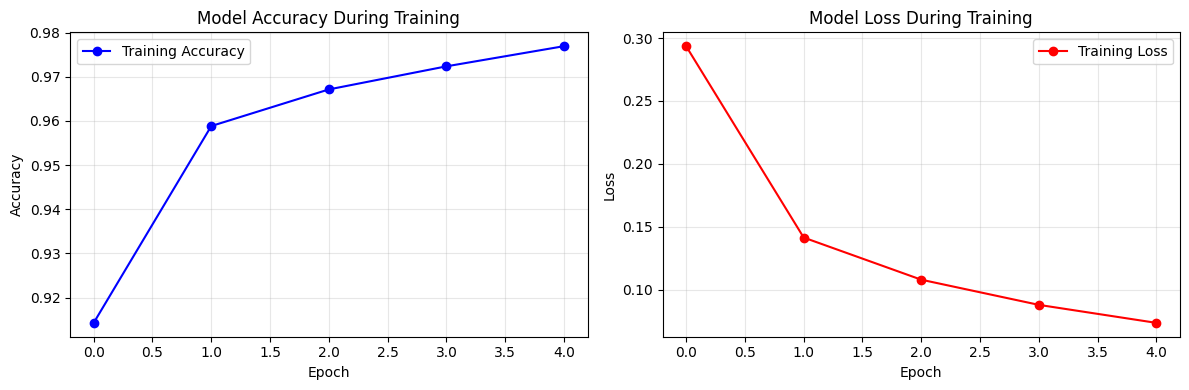

Final training accuracy: 0.9769
Final training loss: 0.0734


In [94]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Training Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'ro-', label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")

### Training Progress Visualization

Let's visualize how our model improved during training:

__Observations:__
- The model fits the data.
- Here, we can see that the accuracy is increased by different epochs.

## Step 9: Evaluate the model

- Evaluate the model using the testing data and print the results.


In [95]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 1s - 2ms/step - accuracy: 0.9736 - loss: 0.0884


[0.0884290263056755, 0.9735999703407288]

__Observation:__

- The accuracy score is 0.979, and the loss is 0.07.

## Step 10: Create a probability model

- Create a probability model by adding the softmax layer to the existing model.



In [96]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

# Test the probability model with 3 samples
print("Sample predictions from probability model:")
sample_predictions = probability_model(x_test[:3])
print(sample_predictions)

Sample predictions from probability model:
tf.Tensor(
[[5.30398552e-07 3.83422155e-10 3.73059038e-06 4.03729209e-05
  8.91532126e-11 7.09010521e-08 1.79632053e-13 9.99920130e-01
  5.11121868e-07 3.46421657e-05]
 [1.65110421e-07 2.08233731e-04 9.99759853e-01 9.31119393e-06
  2.98572690e-12 1.39348740e-05 5.04736235e-08 5.04457134e-08
  8.38522737e-06 5.23152806e-11]
 [8.13010530e-08 9.98475969e-01 6.90712404e-05 1.73626631e-05
  7.32397893e-05 3.97744498e-06 1.81898740e-05 1.22128148e-03
  1.19887736e-04 9.34286902e-07]], shape=(3, 10), dtype=float32)


## Step 11: Visual Prediction Analysis

Let's see how our trained model performs on actual test images with comprehensive visualizations:

Step 11a: Grid view of predictions


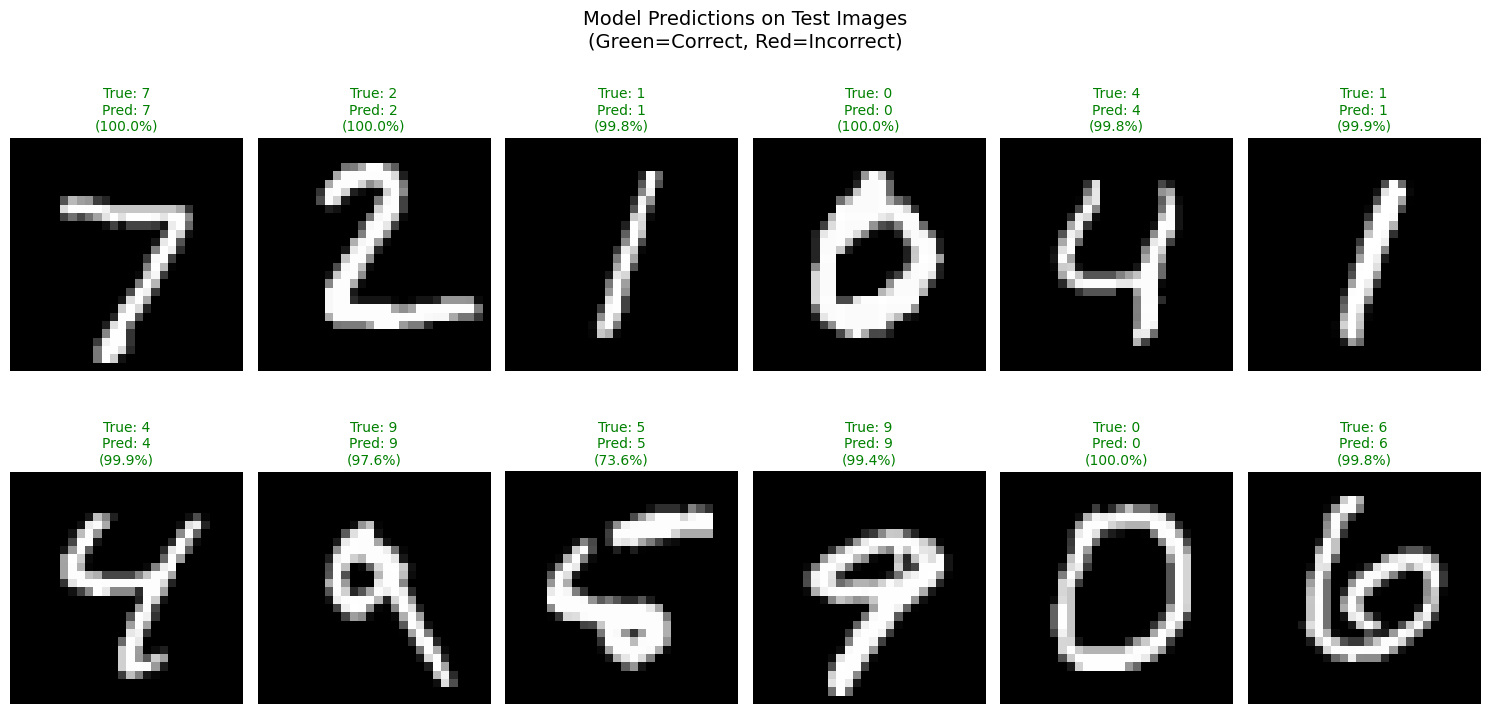


Step 11b: Detailed probability analysis


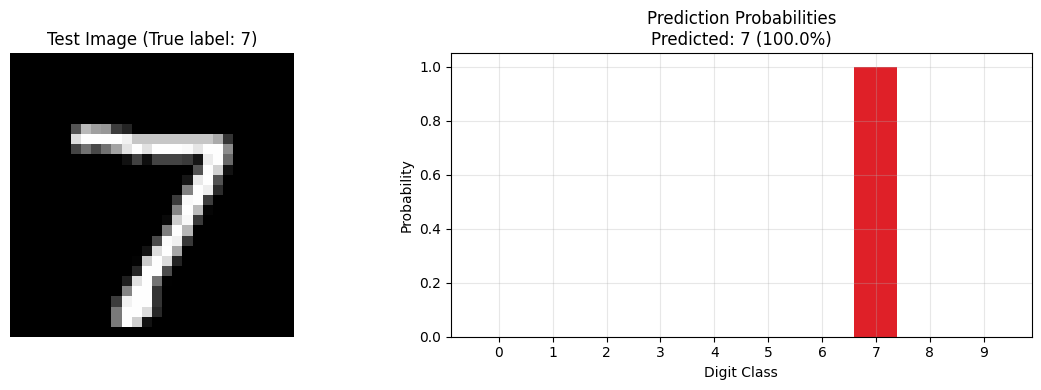


Probability breakdown for the first test image:
Digit 0: 0.00%
Digit 1: 0.00%
Digit 2: 0.00%
Digit 3: 0.00%
Digit 4: 0.00%
Digit 5: 0.00%
Digit 6: 0.00%
Digit 7: 99.99%
Digit 8: 0.00%
Digit 9: 0.00%


In [97]:
# Get predictions for test images
test_predictions = probability_model(x_test[:12])
predicted_labels = np.argmax(test_predictions, axis=1)

print("Step 11a: Grid view of predictions")
# Visualize predictions in a grid
plt.figure(figsize=(15, 8))
for i in range(12):
    plt.subplot(2, 6, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    
    # Color code: green for correct, red for incorrect predictions
    actual = y_test[i]
    predicted = predicted_labels[i]
    confidence = test_predictions[i][predicted] * 100
    
    color = 'green' if actual == predicted else 'red'
    plt.title(f'True: {actual}\nPred: {predicted}\n({confidence:.1f}%)', 
              color=color, fontsize=10)
    plt.axis('off')

plt.suptitle('Model Predictions on Test Images\n(Green=Correct, Red=Incorrect)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nStep 11b: Detailed probability analysis")
# Show probability distribution for a specific prediction
sample_idx = 0
sample_image = x_test[sample_idx]
sample_prediction = test_predictions[sample_idx]

plt.figure(figsize=(12, 4))

# Show the image
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title(f'Test Image (True label: {y_test[sample_idx]})')
plt.axis('off')

# Show probability distribution
plt.subplot(1, 2, 2)
digit_classes = range(10)
plt.bar(digit_classes, sample_prediction, alpha=0.7)
plt.title(f'Prediction Probabilities\nPredicted: {np.argmax(sample_prediction)} ({sample_prediction[np.argmax(sample_prediction)]*100:.1f}%)')
plt.xlabel('Digit Class')
plt.ylabel('Probability')
plt.xticks(digit_classes)
plt.grid(True, alpha=0.3)

# Highlight the predicted class
predicted_class = np.argmax(sample_prediction)
plt.bar(predicted_class, sample_prediction[predicted_class], color='red', alpha=0.8)

plt.tight_layout()
plt.show()

print("\nProbability breakdown for the first test image:")
for i, prob in enumerate(sample_prediction):
    print(f"Digit {i}: {prob*100:.2f}%")

In [98]:
probability_model(x_test[:3])

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[5.30398552e-07, 3.83422155e-10, 3.73059038e-06, 4.03729209e-05,
        8.91532126e-11, 7.09010521e-08, 1.79632053e-13, 9.99920130e-01,
        5.11121868e-07, 3.46421657e-05],
       [1.65110421e-07, 2.08233731e-04, 9.99759853e-01, 9.31119393e-06,
        2.98572690e-12, 1.39348740e-05, 5.04736235e-08, 5.04457134e-08,
        8.38522737e-06, 5.23152806e-11],
       [8.13010530e-08, 9.98475969e-01, 6.90712404e-05, 1.73626631e-05,
        7.32397893e-05, 3.97744498e-06, 1.81898740e-05, 1.22128148e-03,
        1.19887736e-04, 9.34286902e-07]], dtype=float32)>

**Observations:**

- **Grid View**: Shows 12 test images with predictions color-coded (green for correct, red for incorrect)
- **Detailed Analysis**: Displays probability distribution for individual predictions
- **Confidence Levels**: Shows how certain the model is about each prediction
- **Model Performance**: Demonstrates the trained model's ability to classify handwritten digits

**Key Insights:**
- The model achieves high accuracy on most test images
- Confidence levels vary - some predictions are very certain (>99%), others less so
- Visual feedback helps understand when and why the model might make errors